<a href="https://colab.research.google.com/github/hiroshi990/Fraudulent-Transaction/blob/main/Faudaulent_transaction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.4 MB/s eta 0:00:00


In [2]:
#importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("ggplot")
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
%matplotlib inline

In [3]:
df=pd.read_csv(r"/content/Fraud.csv")
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0.0,0.0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0.0,0.0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1.0,0.0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1.0,0.0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0.0,0.0


In [4]:
df.shape

(791143, 11)

In [5]:
df.isnull().sum()

,0
step,0
type,0
amount,0
nameOrig,0
oldbalanceOrg,0
newbalanceOrig,1
nameDest,1
oldbalanceDest,1
newbalanceDest,1
isFraud,1


In [6]:
df.duplicated().sum()

0

Text(0.5, 0, 'amount')

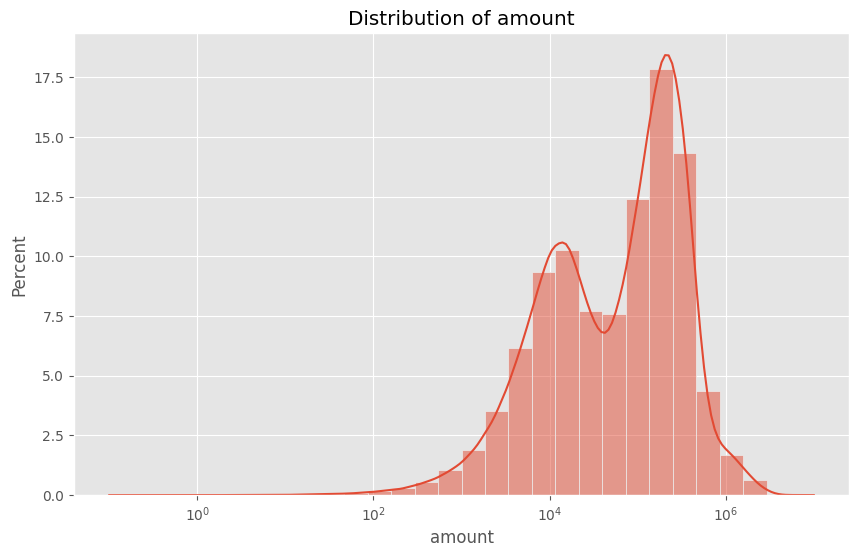

In [7]:
plt.figure(figsize=(10,6))
sns.histplot(data=df,x="amount",log_scale=True,kde=True,bins=30,shrink=1,stat="percent")
plt.title("Distribution of amount")
plt.xlabel("amount")

Text(0.5, 0, 'type of payment ')

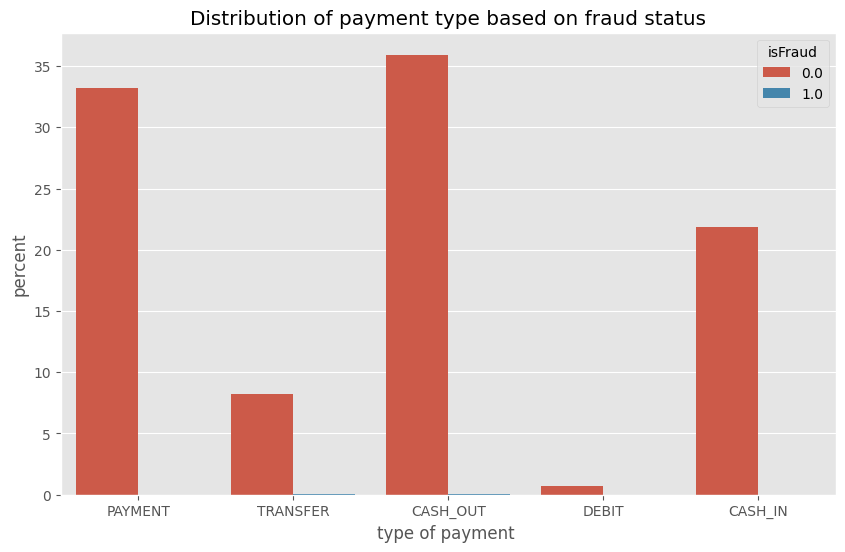

In [8]:
plt.figure(figsize=(10,6))
sns.countplot(data=df,x="type",hue="isFraud",stat="percent")
plt.title("Distribution of payment type based on fraud status")
plt.xlabel("type of payment ")

In [9]:
df["isFraud"].value_counts()

,count
isFraud,
0.0,790684
1.0,458


Text(0.5, 1.0, 'Count of fraud and non fraud transactions')

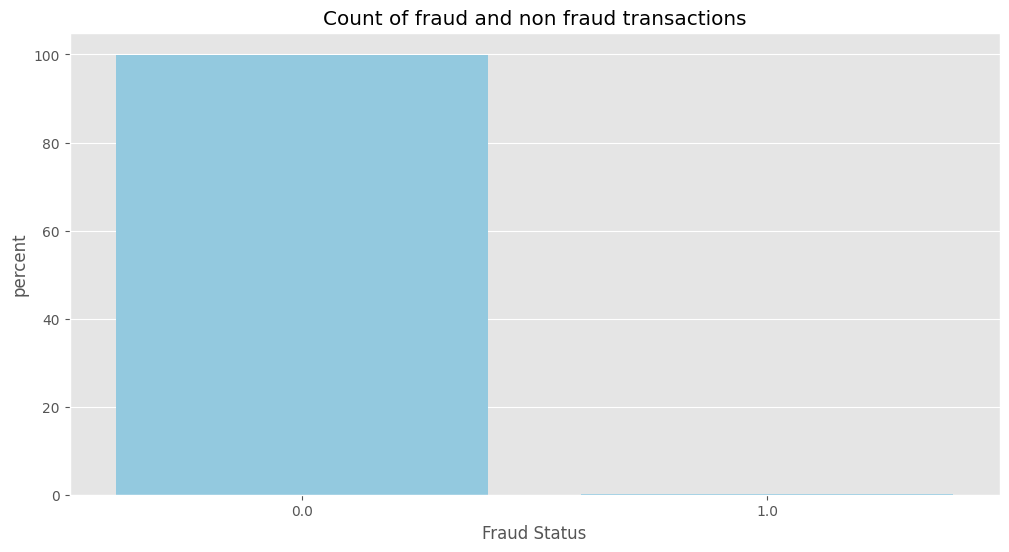

In [10]:
plt.figure(figsize=(12,6))
sns.countplot(data=df,x="isFraud",color="skyblue",stat="percent")
plt.xlabel("Fraud Status")
plt.title("Count of fraud and non fraud transactions")

As evident from the value counts and the plots, the data is highly imabalanced. Training our model on a data like this could lead to high bias towards non fraud transactions. Though tree models like decision tree or random forests does not get affected from imbalance significantly, still its a good practice to make the data balanced.

##Trying different sampling techniques

1. Oversampling

In [11]:
from sklearn.utils import resample
minority_class=df[df["isFraud"]==1]
majority_class=df[df["isFraud"]==0]

sampled_minority=resample(minority_class,replace=True,n_samples=len(majority_class), random_state=42)

print(len(sampled_minority))
print(len(majority_class))

790684
790684


([0, 1, 2, 3, 4],
 [Text(0, 0, 'PAYMENT'),
  Text(1, 0, 'TRANSFER'),
  Text(2, 0, 'CASH_OUT'),
  Text(3, 0, 'DEBIT'),
  Text(4, 0, 'CASH_IN')])

<Figure size 1200x600 with 0 Axes>

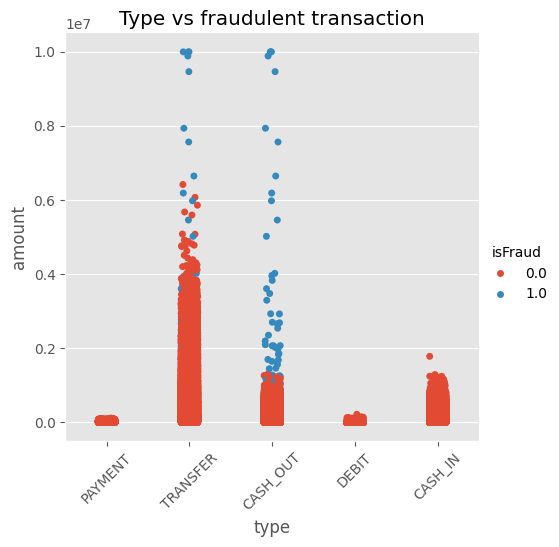

In [12]:
plt.figure(figsize=(12,6))
sns.catplot(data=df,x="type",y="amount",hue="isFraud")
plt.title("Type vs fraudulent transaction")
plt.xticks(rotation=45)


Only transfer and cashout has the fraudulent transactions.\
transactions with large amount of money are mostly fraudulent

In [13]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0.0,0.0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0.0,0.0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1.0,0.0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1.0,0.0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0.0,0.0


<Axes: xlabel='amount'>

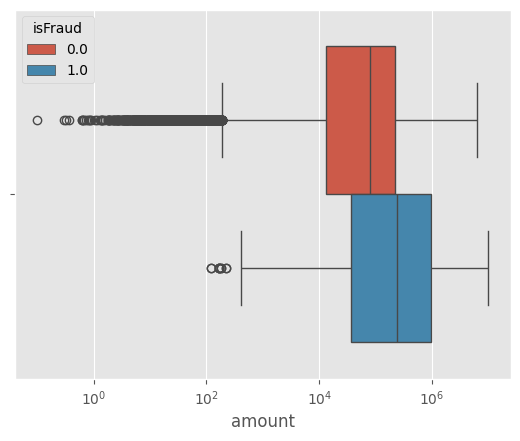

In [14]:
plt.figure()
sns.boxplot(data=df,x="amount",hue="isFraud",log_scale=True)

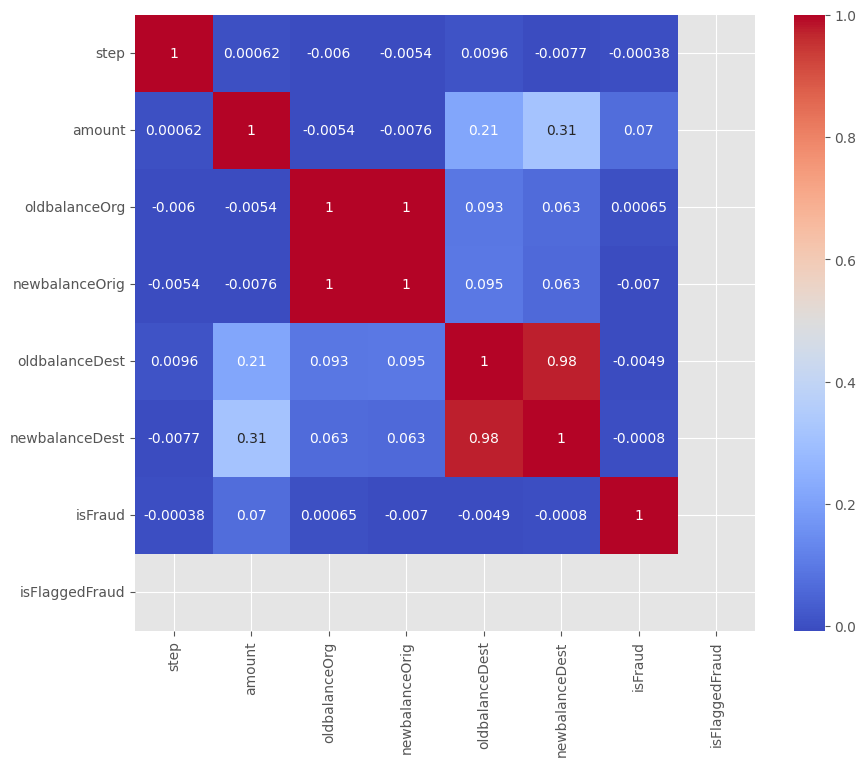

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
correlation_matrix = df.corr(numeric_only=True)
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

In [16]:
sampled_minority[sampled_minority["isFraud"]==1]


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
58307,9,TRANSFER,21922.00,C102617052,21922.00,0.0,C760675871,0.00,0.00,1.0,0.0
751771,38,TRANSFER,21367.00,C1884262933,21367.00,0.0,C69223691,0.00,0.00,1.0,0.0
576373,32,CASH_OUT,604933.67,C1085892947,604933.67,0.0,C1138178950,35839.70,640773.38,1.0,0.0
572855,24,CASH_OUT,6844.73,C2006451816,6844.73,0.0,C1380348902,264100.70,270945.42,1.0,0.0
69202,9,CASH_OUT,1055.00,C1764109750,1055.00,0.0,C1522743169,75179.00,0.00,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
193765,13,TRANSFER,48375.02,C920803432,48375.02,0.0,C1767389067,0.00,0.00,1.0,0.0
56478,9,CASH_OUT,1154353.99,C1034219836,1154353.99,0.0,C1195589213,162222.00,1965587.60,1.0,0.0
708913,37,CASH_OUT,1842.00,C323132484,1842.00,0.0,C1737682079,0.00,1842.00,1.0,0.0
576363,32,CASH_OUT,81867.07,C1861680707,81867.07,0.0,C2064372710,135117.98,216985.05,1.0,0.0


In [17]:
new_balanced_df=pd.concat([sampled_minority,majority_class])
new_balanced_df

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
58307,9,TRANSFER,21922.00,C102617052,21922.00,0.0,C760675871,0.00,0.00,1.0,0.0
751771,38,TRANSFER,21367.00,C1884262933,21367.00,0.0,C69223691,0.00,0.00,1.0,0.0
576373,32,CASH_OUT,604933.67,C1085892947,604933.67,0.0,C1138178950,35839.70,640773.38,1.0,0.0
572855,24,CASH_OUT,6844.73,C2006451816,6844.73,0.0,C1380348902,264100.70,270945.42,1.0,0.0
69202,9,CASH_OUT,1055.00,C1764109750,1055.00,0.0,C1522743169,75179.00,0.00,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
791137,40,PAYMENT,1647.86,C657443847,0.00,0.0,M448139215,0.00,0.00,0.0,0.0
791138,40,PAYMENT,21896.04,C767822613,15218.00,0.0,M630353405,0.00,0.00,0.0,0.0
791139,40,CASH_OUT,119403.47,C2089079484,9957.00,0.0,C1361717036,332160.91,628484.15,0.0,0.0
791140,40,PAYMENT,5129.15,C1449550484,0.00,0.0,M1542936558,0.00,0.00,0.0,0.0


In [18]:
new_df=new_balanced_df.sample(frac=1).reset_index(drop=True)
new_df

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,11,CASH_OUT,60367.46,C1295668572,0.00,0.0,C991670268,1846085.05,2048161.62,0.0,0.0
1,39,CASH_OUT,39013.30,C888856721,39013.30,0.0,C202101281,924162.55,1089489.11,1.0,0.0
2,8,TRANSFER,43092.00,C1683174795,43092.00,0.0,C427998326,0.00,0.00,1.0,0.0
3,15,PAYMENT,7795.21,C850553682,0.00,0.0,M1777189977,0.00,0.00,0.0,0.0
4,17,TRANSFER,195351.76,C1420261366,195351.76,0.0,C639808302,0.00,0.00,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
1581363,21,TRANSFER,158299.34,C278180302,158299.34,0.0,C1551346623,0.00,0.00,1.0,0.0
1581364,31,CASH_OUT,587031.20,C1534882693,587031.20,0.0,C534658891,338247.75,925278.94,1.0,0.0
1581365,28,TRANSFER,491517.77,C1029198062,491517.77,0.0,C1534111155,0.00,0.00,1.0,0.0
1581366,34,CASH_OUT,71693.42,C1845753498,71693.42,0.0,C967051629,0.00,71693.42,1.0,0.0


In [19]:
#Defining the target and feature columns
X=new_df.drop("isFraud",axis=1)
y=new_df["isFraud"]

In [20]:
#label encoding categorical columns
categorical_cols=X.select_dtypes(["object"]).columns
for col in categorical_cols:
  le=LabelEncoder()
  X[col]=le.fit_transform(X[col])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


# Logistic Regression
lr = LogisticRegression()
lr.fit(X_train, y_train)

# Decision Tree
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

# XGBoost
xgb = XGBClassifier()
xgb.fit(X_train, y_train)

# CatBoost
catb = CatBoostClassifier()
catb.fit(X_train, y_train)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Learning rate set to 0.205484
0:	learn: 0.3792131	total: 259ms	remaining: 4m 18s
1:	learn: 0.2376238	total: 442ms	remaining: 3m 40s
2:	learn: 0.1875711	total: 638ms	remaining: 3m 31s
3:	learn: 0.1544514	total: 961ms	remaining: 3m 59s
4:	learn: 0.1249481	total: 1.31s	remaining: 4m 20s
5:	learn: 0.1028775	total: 1.63s	remaining: 4m 30s
6:	learn: 0.0954058	total: 1.98s	remaining: 4m 40s
7:	learn: 0.0912480	total: 2.33s	remaining: 4m 48s
8:	learn: 0.0779022	total: 2.67s	remaining: 4m 54s
9:	learn: 0.0736197	total: 3.01s	remaining: 4m 58s
10:	learn: 0.0677615	total: 3.36s	remaining: 5m 2s
11:	learn: 0.0652588	total: 3.7s	remaining: 5m 4s
12:	learn: 0.0630011	total: 4.05s	remaining: 5m 7s
13:	learn: 0.0606919	total: 4.44s	remaining: 5m 12s
14:	learn: 0.0559360	total: 4.65s	remaining: 5m 5s
15:	learn: 0.0533433	total: 4.83s	remaining: 4m 57s
16:	learn: 0.0510800	total: 5.02s	remaining: 4m 50s
17:	learn: 0.0495496	total: 5.21s	remaining: 4m 44s
18:	learn: 0.0480337	total: 5.4s	remaining: 4m 38

In [21]:
#function to evaluate the models
def evaluate_model(x_test,y_test,model):
  y_pred=model.predict(x_test)
  accuracy=accuracy_score(y_test,y_pred)
  precision = precision_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)
  roc_auc = roc_auc_score(y_test, y_pred)
  return accuracy, precision, recall, roc_auc


In [22]:
lr_acc,lr_precision,lr_recall,lr_roc_auc=evaluate_model(X_test,y_test,lr)
dt_acc,dt_precision,dt_recall,dt_roc_auc=evaluate_model(X_test,y_test,dt)
xgb_acc,xgb_precision,xgb_recall,xgb_roc_auc=evaluate_model(X_test,y_test,xgb)
catb_acc,catb_precision,catb_recall,catb_roc_auc=evaluate_model(X_test,y_test,catb)

In [23]:
print("Logistic Regression - Accuracy:", lr_acc, "Precision:", lr_precision, "Recall:", lr_recall, "ROC AUC:", lr_roc_auc)
print("Decision Tree - Accuracy:", dt_acc, "Precision:", dt_precision, "Recall:", dt_recall, "ROC AUC:", dt_roc_auc)
print("XGBoost - Accuracy:", xgb_acc, "Precision:", xgb_precision, "Recall:", xgb_recall, "ROC AUC:", xgb_roc_auc)
print("CatBoost - Accuracy:", catb_acc, "Precision:", catb_precision, "Recall:", catb_recall, "ROC AUC:", catb_roc_auc)

Logistic Regression - Accuracy: 0.8880527643751936 Precision: 0.9104351160695972 Recall: 0.8607793456127555 ROC AUC: 0.8880520170385413
Decision Tree - Accuracy: 0.9998967140306612 Precision: 0.9997934650660911 Recall: 1.0 ROC AUC: 0.999896716860867
XGBoost - Accuracy: 0.9998334777229028 Precision: 0.9996670572071579 Recall: 1.0 ROC AUC: 0.9998334822858878
CatBoost - Accuracy: 0.9995425907072137 Precision: 0.9990859925194595 Recall: 1.0 ROC AUC: 0.9995426032409828


There is not much difference in terms of performances of models but catboost perfroms the best with an accuracy of 99% and 0.99 ROC AUC score

### creating the preprocessing pipeline

In [24]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

In [33]:
numerical_features = [ 'amount', 'nameOrig' ,'oldbalanceOrg' ,  'newbalanceOrig' , 'nameDest' , 'oldbalanceDest', 'newbalanceDest']
categorical_features = ['step','type']
preprocessor = ColumnTransformer(
    transformers=[
        ('numerical', StandardScaler(), numerical_features),  # Apply standardization to numerical features
        ('categorical', 'passthrough', categorical_features),  # Passing through categorical features
    ]
)

In [34]:
feature_selector = SelectKBest(score_func=f_classif, k=7)
feature_selector

SelectKBest(k=7)

In [36]:
# Build the pipeline
pipeline_lr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('feature_selector', feature_selector),
    ('classifier', lr)
])

pipeline_dt = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('feature_selector', feature_selector),
    ('classifier', dt)
])

pipeline_xgb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('feature_selector', feature_selector),
    ('classifier', xgb)
])

pipeline_catboost = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('feature_selector', feature_selector),
    ('classifier', catb)
])

# Training the pipelines
pipeline_lr.fit(X_train, y_train)
pipeline_dt.fit(X_train, y_train)
pipeline_xgb.fit(X_train, y_train)
pipeline_catboost.fit(X_train, y_train)

# Evaluating the pipelines
def evaluate_pipeline(pipeline, X, y):
    y_pred = pipeline.predict(X)
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    roc_auc = roc_auc_score(y, y_pred)
    conf_matrix=confusion_matrix(y_test,y_pred)
    return accuracy, precision, recall, roc_auc,conf_matrix

lr_accuracy, lr_precision, lr_recall, lr_roc_auc,lr_conf_matrix = evaluate_pipeline(pipeline_lr, X_test, y_test)
dt_accuracy, dt_precision, dt_recall, dt_roc_auc,dt_conf_matrix = evaluate_pipeline(pipeline_dt, X_test, y_test)
xgb_accuracy, xgb_precision, xgb_recall, xgb_roc_auc,xgb_conf_matrix = evaluate_pipeline(pipeline_xgb, X_test, y_test)
catboost_accuracy, catboost_precision, catboost_recall, catboost_roc_auc,catb_conf_matrix = evaluate_pipeline(pipeline_catboost, X_test, y_test)

Learning rate set to 0.205484
0:	learn: 0.4228076	total: 190ms	remaining: 3m 9s
1:	learn: 0.3214793	total: 371ms	remaining: 3m 5s
2:	learn: 0.2800957	total: 556ms	remaining: 3m 4s
3:	learn: 0.2583243	total: 738ms	remaining: 3m 3s
4:	learn: 0.2482210	total: 942ms	remaining: 3m 7s
5:	learn: 0.2328162	total: 1.13s	remaining: 3m 6s
6:	learn: 0.2260770	total: 1.31s	remaining: 3m 6s
7:	learn: 0.2173062	total: 1.48s	remaining: 3m 3s
8:	learn: 0.2115745	total: 1.67s	remaining: 3m 4s
9:	learn: 0.2036750	total: 1.96s	remaining: 3m 14s
10:	learn: 0.2012720	total: 2.3s	remaining: 3m 27s
11:	learn: 0.1940565	total: 2.65s	remaining: 3m 38s
12:	learn: 0.1914223	total: 3s	remaining: 3m 47s
13:	learn: 0.1874291	total: 3.34s	remaining: 3m 54s
14:	learn: 0.1845703	total: 3.65s	remaining: 3m 59s
15:	learn: 0.1804196	total: 4s	remaining: 4m 6s
16:	learn: 0.1766392	total: 4.36s	remaining: 4m 11s
17:	learn: 0.1734716	total: 4.74s	remaining: 4m 18s
18:	learn: 0.1705617	total: 5.12s	remaining: 4m 24s
19:	learn

In [37]:
# evaluation metrics
print("Logistic Regression - Accuracy:", lr_accuracy, "Precision:", lr_precision, "Recall:", lr_recall, "ROC AUC:", lr_roc_auc,"confusion matrix:",lr_conf_matrix)
print("Decision Tree - Accuracy:", dt_accuracy, "Precision:", dt_precision, "Recall:", dt_recall, "ROC AUC:", dt_roc_auc,"confusion matrix:",dt_conf_matrix)
print("XGBoost - Accuracy:", xgb_accuracy, "Precision:", xgb_precision, "Recall:", xgb_recall, "ROC AUC:", xgb_roc_auc,"confusion matrix:",xgb_conf_matrix)
print("CatBoost - Accuracy:", catboost_accuracy, "Precision:", catboost_precision, "Recall:", catboost_recall, "ROC AUC:", catboost_roc_auc,"confusion matrix:",catb_conf_matrix)


Logistic Regression - Accuracy: 0.7762446486274559 Precision: 0.7697383858551345 Recall: 0.7882874717009768 ROC AUC: 0.7762449786206687 confusion matrix: [[181278  55934]
 [ 50218 186981]]
Decision Tree - Accuracy: 0.9998292619690522 Precision: 0.9996586311530681 Recall: 1.0 ROC AUC: 0.9998292666475558 confusion matrix: [[237131     81]
 [     0 237199]]
XGBoost - Accuracy: 0.9987352738448307 Precision: 0.9974768607100954 Recall: 1.0 ROC AUC: 0.9987353085004131 confusion matrix: [[236612    600]
 [     0 237199]]
CatBoost - Accuracy: 0.999656416061179 Precision: 0.9993132851930806 Recall: 1.0 ROC AUC: 0.9996564254759456 confusion matrix: [[237049    163]
 [     0 237199]]


In [54]:
#function to plot the confusion matrix
def plot_confusion_matrix(conf_matrix):
  plt.figure(figsize=(10,6))
  conf_matrix_df=pd.DataFrame(conf_matrix)
  labels=["True Positive","True Negative","False Positive","False Negative"]
  data=[conf_matrix_df[0][0],conf_matrix_df[1][1],conf_matrix_df[1][0],conf_matrix_df[0][1]]
  plt.bar(labels,data,color=["blue","red","green","yellow"])
  plt.title("True and False predictions")
  plt.xlabel("Predictions")
  plt.ylabel("count")
  plt.show()

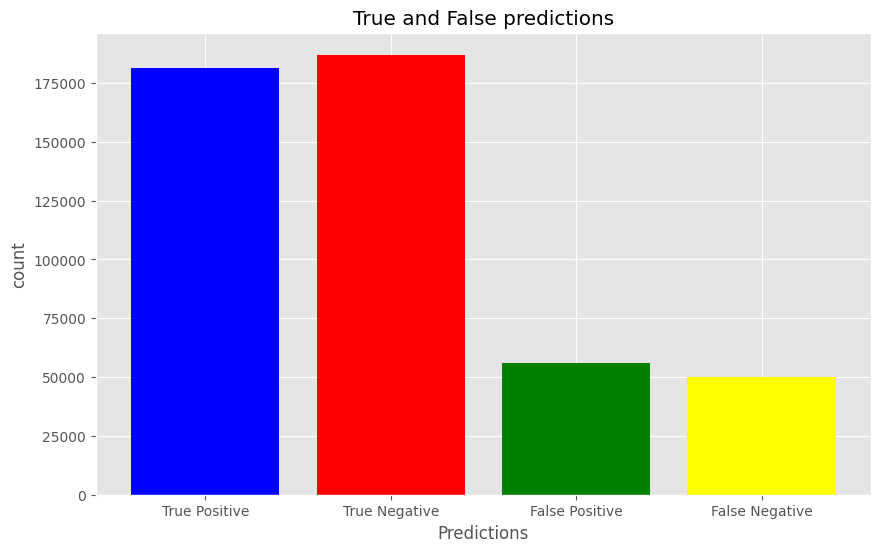

Logistc Regression: None


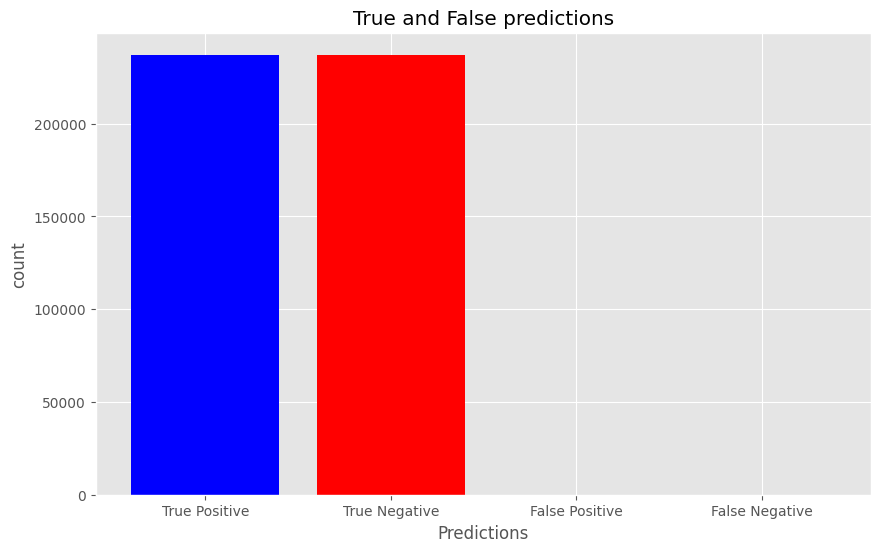

Decision Tree: None


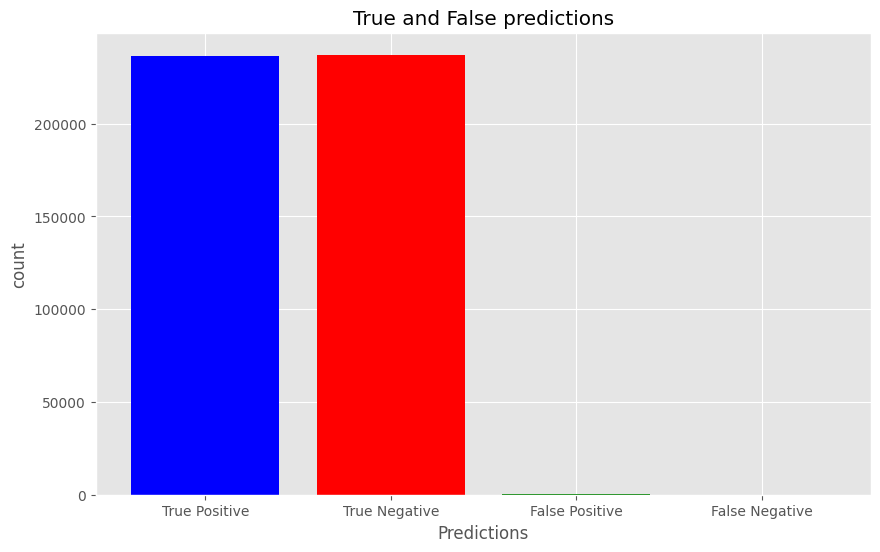

Xgboost: None


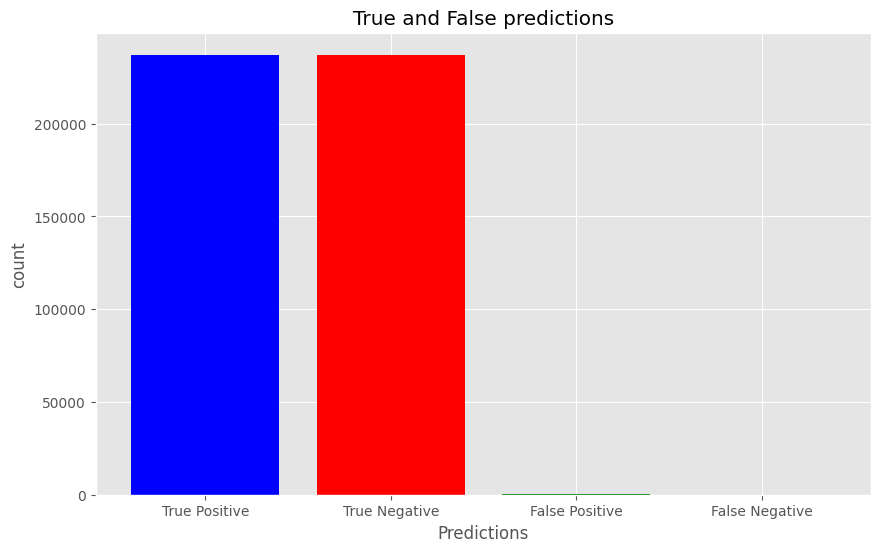

Catboost: None


In [55]:
#Printing the predictions plots
print("Logistic Regression:",plot_confusion_matrix(lr_conf_matrix))
print("Decision Tree:",plot_confusion_matrix(dt_conf_matrix))
print("Xgboost:",plot_confusion_matrix(xgb_conf_matrix))
print("Catboost:",plot_confusion_matrix(catb_conf_matrix))